# Information Theoretic Model Predictive Control on a TurtleBot

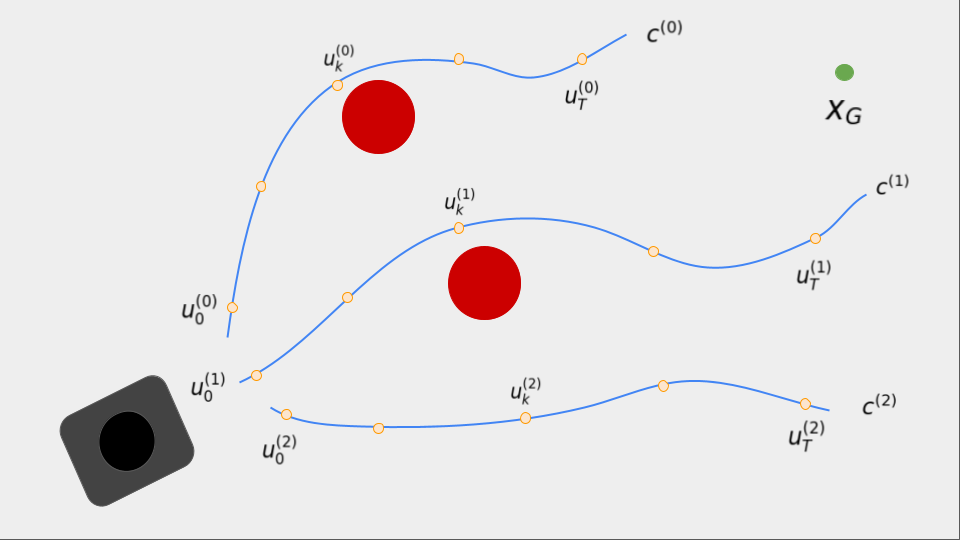

In [6]:
!pip install -U matplotlib

In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, splev

np.random.seed(123456)
%matplotlib inline

In [8]:
class MPPI:
    def __init__(self, dt, T, Q, R, goal, goal_tol, obstacles, obstacle_radius, num_samples = 100):
        """
        Initializes the MPPI controller.

        Parameters:
        - dt: Time step (seconds).
        - T: Number of time steps for the prediction horizon.
        - Q: State cost weight.
        - R: Control input cost weight.
        - goal: Goal position [xG, yG].
        - goal_tol: Tolerance for reaching the goal.
        - obstacles: List of obstacle positions [x, y] in the map.
        - obstacle_radius: Radius of avoidance around obstacles.
        - num_samples: Number of trajectories to sample.
        """
        ## DO NOT CHANGE THESE PARAMETERS ##
        self.dt = dt # time-step for dynamics
        self.T = T # Horizon time
        self.Q = Q # Weight for state-cost term
        self.R = R # Weight for control-cost term
        self.goal = goal # Goal state
        self.goal_tol = goal_tol # Tolerance of reaching goal_state
        self.obstacles = obstacles # List of obstacles
        self.obstacle_radius = obstacle_radius # Margine of error for obstacle avoidance constraint
        self.lamda = 100.  # Temperature parameter for path integral
        self.N = num_samples # Number of trajectories to sample

        self.u_means = np.zeros((self.T, 2))
        self.time_horizon = np.arange(self.T) * self.dt

    def simulate_dynamics(self, x, u):
        """
        Simulate the robot dynamics using simple bicycle kinematics.
        """
        v, omega = u

        theta = x[2]
        x_new = np.zeros_like(x)
        x_new[0] = x[0] + v * np.cos(theta) * self.dt
        x_new[1] = x[1] + v * np.sin(theta) * self.dt
        x_new[2] = theta + omega * self.dt

        return x_new

    def compute_cost(self, U, trajectory):
        """
        Compute the cost of a trajectory with respect to the goal and obstacles.

        Parameters:
        - U: (T, 2) np.array. Sequence of control inputs for the trajectory.
        - trajectory: (T, 3) np.array. Sequence of states in the trajectory.

        Returns:
        - cost: int. Total cost of the trajectory.
        """
        cost = 0.0

        ### CODE STARTS HERE ###
        # Hints:
        # 1. Implement the goal-penalty state-cost function (Use the L2-norm)
        for t in range(self.T):
            distance_to_goal = np.linalg.norm(trajectory[t, :2] - self.goal)
            cost += self.Q * distance_to_goal ** 2
        # 2. Implement the control-cost function
            cost += self.R * np.linalg.norm(U[t]) ** 2
        # 3. Implement the obstacle avoidance constraint. (Use the L2-norm)
        # Note: ensure the cost term when the obstacle constraint is not satisfied is very high, ex. b/w 100.0 to 1000.0
            for obs in self.obstacles:
                distance_to_obstacle = np.linalg.norm(trajectory[t, :2] - np.array(obs))
                if distance_to_obstacle < self.obstacle_radius:
                    cost += 1000.0  # High penalty for collision
        ### CODE ENDS HERE ###

        return cost

    def sample_trajectory(self, x0):
        """
        Sample a trajectory using random control inputs.

        Parameters:
        - x0: Initial state.

        Returns:
        - trajectory: (T, 3) np.array. The sequence of states [x, y, theta] in the trajectory.
        - U: (T, 2) np.array. The sequence of control inputs for this trajectory.
        """

        trajectory = np.zeros((self.T, 3))

        ### CODE STARTS HERE ###
        ## Hints:
        U = np.zeros((self.T, 2))

        # 1. Initialize the trajectory to start at x0
        trajectory[0] = x0

        # 2. Sample control perturbations based on the distribution from part (i).
        # Hint: np.random.randn with sigma = 1 (or Identity, I)
        perturbations = np.random.randn(self.T, 2)  # Random noise with standard deviation of 1
        # 3. Add the perturbations to the current estimated optimal control sequence
        # 4. Rollout the dynamics using the new control sequence and store the states into the trajectory
        # Loop over the time steps to generate the trajectory
        for t in range(self.T):
            # Add perturbations to the control input mean (assumed to be zero here)
            U[t] = self.u_means[t] + perturbations[t]

            # Simulate the next state using the perturbed control inputs
            if t < self.T - 1:
                trajectory[t + 1] = self.simulate_dynamics(trajectory[t], U[t])

        ### CODE ENDS HERE ###

        return trajectory, U

    def mppi_control_step(self, x0):
        """
        MPPI controller: Find the optimal control trajectory to minimize the cost.

        Parameters:
        - x0: Initial state.

        Returns:
        - u0_star: (2, ) np.array. The next optimal control input.
        """

        trajectory_samples = []
        control_samples = []
        costs = []

        U_opt = np.zeros((self.T, 2))
        u0_star = np.array([0., 0.])

        ### CODE STARTS HERE ###
        # 1. Sample N trajectories and control sequences, compute their costs and store them
        for i in range(self.N):
            trajectory, U = self.sample_trajectory(x0)
            cost = self.compute_cost(U, trajectory)

            trajectory_samples.append(trajectory)
            control_samples.append(U)
            costs.append(cost)

        # 2. Compute the weights of these trajectories using Eqn (9) in the problem.
        min_cost = min(costs)
        exp_weights = np.exp(-self.lamda * (np.array(costs) - min_cost))

        # Normalize the weights
        weights = exp_weights / np.sum(exp_weights)

        # 3. Find the optimal control sequence, U*_k, using Eqn (10) in the problem.
        weighted_trajectory = np.zeros_like(U_opt)

        for i in range(self.N):
            weighted_trajectory += weights[i] * control_samples[i]

        # Update the optimal control sequence
        U_opt = weighted_trajectory

        # Hint: You can use self.U_star to store U*_k at each iteration in order to access it in future iterations.
        # 4. Return the next optimal control input, u0*.
        u0_star = U_opt[0]
        ### CODE ENDS HERE ###

        return u0_star # Return the first control input from the optimal sequence, U*_k

    def run_simulation(self, x0):
      """
      Run the MPPI simulation to find the optimal trajectory.

      Parameters:
      - x0: Initial state.

      Returns:
      - trajectory: np.ndarray. Sequence of states in the optimal trajectory.
      """

      x = x0.copy()
      trajectory = [x[:2]]
      max_iters = 0

      while(np.linalg.norm(x[:2] - self.goal) > self.goal_tol and max_iters <= 1000):

          # Run MPPI to get the optimal control inputs
          for i in range(self.T):

              #1. Get optimal control input at current state by calling mppi_control_step
              u_opt = self.mppi_control_step(x)

              #2. Simulate robot dynamics with the optimal control input
              x = self.simulate_dynamics(x, u_opt)

              #3. Store the 2D position (x,y) of the state
              trajectory.append(x[:2])

              # Check for exit condition
              if np.linalg.norm(x[:2] - self.goal) <= self.goal_tol:
                  print("Goal reached!")
                  break
          max_iters += 1

      print("Found optimal trajectory")
      return np.array(trajectory)

    def smooth_controls(self, u_opt):
        """
        Smooth the control sequence using a polynomial spline.
        """
        v_spline = CubicSpline(self.time_horizon, u_opt[:, 0], bc_type='natural')
        omega_spline = CubicSpline(self.time_horizon, u_opt[:, 1], bc_type='natural')

        # Sample the smoothed controls at discrete time steps
        smoothed_u = np.zeros_like(u_opt)
        for t, time in enumerate(self.time_horizon):
            smoothed_u[t, 0] = v_spline(time)
            smoothed_u[t, 1] = omega_spline(time)

        return smoothed_u

def plot_trajectory(trajectory, goal, obstacles, start):
    """
    Plot the robot's trajectory, goal, and obstacles on a 2D map.
    """
    plt.figure()
    plt.plot(trajectory[:, 0], trajectory[:, 1], '--', label='Trajectory')
    plt.scatter(start[0], start[1], color = 'green', label = 'Start', s=100)
    plt.scatter(goal[0], goal[1], color='red', label='Goal', s=100)

    for obs in obstacles:
        plt.scatter(obs[0], obs[1], color='black', label='Obstacle', s=100)

    plt.xlim([-1, 7])
    plt.ylim([-1, 7])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
def compute_smoothed_path(path, v_desired=0.15, spline_alpha=0.05, dt: float = 0.1) -> np.ndarray:
    """ Get the full smoothed path sampled with fixed time steps

    Args:
        dt (float): sampling duration in [seconds]

    Returns:
        np.ndarray: smoothed trajectory sampled @ dt
    """

    ts_n = np.shape(path)[0]
    ts = np.zeros(ts_n)
    for i in range(ts_n-1):
        ts[i+1] = np.linalg.norm(path[i+1] - path[i]) / v_desired
        ts[i+1] = ts[i+1] + ts[i]

    path_x_spline = scipy.interpolate.splrep(ts, path[: ,0], k=3, s=spline_alpha)
    path_y_spline = scipy.interpolate.splrep(ts, path[: ,1], k=3, s=spline_alpha)
    duration=ts[-1]

    time = np.arange(0., duration, dt)
    path = np.zeros((time.shape[0], 2))
    path[:, 0] = splev(time, path_x_spline, der=0)
    path[:, 1] = splev(time, path_y_spline, der=0)

    return path


def run_mppi(dt, N, Q, R, x0, goal, goal_tol, obstacles, obstacle_radius):

  # Initialize MPPI controller
  mppi = MPPI(dt, N, Q, R, goal, goal_tol, obstacles, obstacle_radius)

  # Simulate MPPI to obtain an optimal trajectory to goal state
  trajectory = mppi.run_simulation(x0)

  # Smoothen the trajectory
  trajectory = compute_smoothed_path(trajectory)

  # Plot the trajectory
  plot_trajectory(trajectory, goal, obstacles, x0)

Goal reached!
Found optimal trajectory


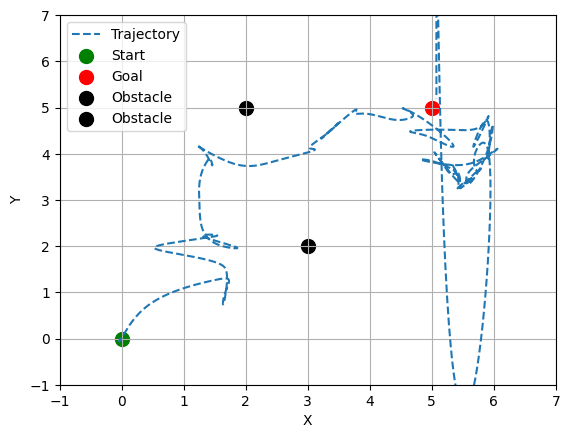

In [10]:
# Define parameters
dt = 0.5  # Time step (seconds)
T = 20    # Prediction horizon (number of time steps)
Q = 1.    # State cost weight (penalize distance to goal)
R = 10.   # Control cost weight (penalize large control inputs)

# Goal parameters
goal = np.array([5., 5.])   # Goal position
goal_tol = 0.3              # Goal tolerance

# Obstacle parameters
obstacles = [np.array([2., 5.]), np.array([3., 2.])]
obstacle_radius = 1.0  # Obstacle avoidance radius

# Initial state (x, y, theta)
x0 = np.array([0., 0., np.pi/4])

run_mppi(dt, T, Q, R, x0, goal, goal_tol, obstacles, obstacle_radius)

## Adding More Obstacles

Run the cell-blocks below and save the trajectory plot that is generated.

If you find that the trajectory is not smooth or that there is too much noise, try running it a few more times to get a smoother trajectory.

<!-- Some other things to try if you have extra time (COMPLETEY OPTIONAL):


*   Modify the goal_tol
*   Tweak the obstacle avoidance cost
*   Smoothen the control inputs as well using the helper function -->





Goal reached!
Found optimal trajectory


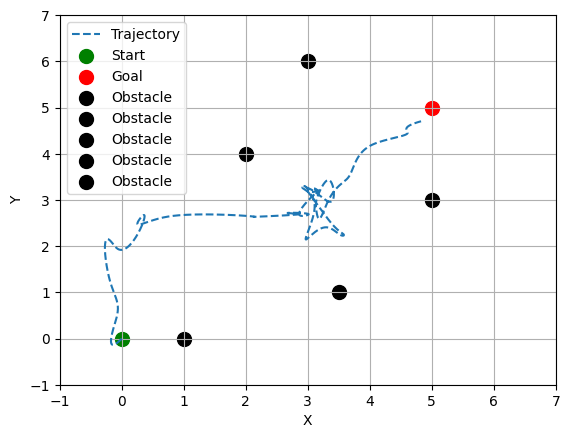

In [11]:
# Define new obstacle parameters
goal_tol = 0.4
obstacles = [np.array([3., 6.]),
              np.array([2., 4.]),
              np.array([5., 3.]),
              np.array([1., 0.]),
              np.array([3.5, 1.])
            ]  # Obstacle positions

run_mppi(dt, T, Q, R, x0, goal, goal_tol, obstacles, obstacle_radius)

# Save the above 2 plots and add them to your final pdf for submission!